# Anwendung des Classifers

## Laden von Paketen

 Die Anwendung des Classifiers ist so einfach wie möglich gestaltet. In einem ersten Schritt wählen wir unser Enviorment `future-skill-classification` und laden die für die Vorhersage der Labels nötigen Pakete:

In [62]:
import pyreadr  # Zum Lesen von R-Daten in Python
import os       # Funktionen zum Interagieren mit dem Betriebssystem
import pandas as pd  # Datenanalyse und -manipulation mit DataFrames
import re # Regrex-Paket für die Bereinigung von Strings
from tqdm import tqdm # Paket fürs Anzeigen von Fortschritt beim Ausführen von Funktionen
from setfit import SetFitModel  # Zum Laden des SetFit-Modells von Hugging Face bzw. aus dem lokalen Ordner heraus

## Laden der HEX-Daten

Wir checken das Root-Verzeichnis. Stimmt dieses nicht, bestimmen wir das Korrekte und lesen `db_hex.rds` ein. 

In [63]:
# checke home-verzeichnis
print(os.getcwd())
# setze home-verzeichnis
os.chdir('c:/Users/Hueck/OneDrive/Dokumente/GitHub/future_skill_classification/')
# lade HEX-Daten. Hinweise: Zurückgegben eine Liste mit einem Element (dem Data Frame).
# Dieses lassen wir uns mit `.values())[0]` zurückgeben.
df_hex = list(pyreadr.read_r('data/db_hex.rds').values())[0]

c:\Users\Hueck\OneDrive\Dokumente\GitHub\future_skill_classification


Um die Classifier zu testen, wenden wir ihn vorerst nur auf 10.000 zufällig gezogene Zeilen an. Dafür *ziehen* wir die entsprechende Stichprobe und speichern sie in dem Objekt `df_hex_sample`.

In [88]:
df_hex_sample = df_hex.sample(n=100000)

In einem weiteren Schritt werden die Daten für die Klassifikation vorbereitet: 

- `NAs` werden durch leere Strings ersetzt
- Die Variablen `titel` und `kursbeschreibung` zusammengefügt und – falls eine Kursbeschreibung vorhanden ist – ein Doppelpunkt zwischen `titel` und `kursbeschreibung` gesetzt.

In [89]:
# Ersetze NaN-Werte in den Spalten 'titel' und 'kursbeschreibung' durch leere Strings
df_hex_sample['titel'] = df_hex_sample['titel'].fillna('')
df_hex_sample['kursbeschreibung'] = df_hex_sample['kursbeschreibung'].fillna('')
df_hex_sample['lernziele'] = df_hex_sample['lernziele'].fillna('')


# Kombiniere die Spalten und füge den Doppelpunkt nur hinzu, wenn eine Kursbeschreibung vorhanden ist
df_hex_sample['sentence'] = df_hex_sample.apply(
    lambda row: row['titel'] 
                + (": " + row['kursbeschreibung'] if row['kursbeschreibung'] else "")
                + (". Lernziele: " + row['lernziele'] if row['lernziele'] else ""),
    axis=1
)


## Definition von Funktionen für die Vorhersage von Future Skills

Um die Future Skills der Kurse der Datenbank mit unserem Modell vorhersagen zu können, erstellen wir eine Funktion, die durch die Zeilen der `db_hex.rds` iteriert und die entsprechenden Schätzungen anhand der oben präparierten `sentence`-Variable vornimmt.

In [90]:
# Fortschrittsbalken für Pandas aktivieren, um die Fortschritt der Prädiktion besser nachvollziehen zu können.
tqdm.pandas()

# Definiere eine Funktion, die das Modell auf eine Kursbeschreibung anwendet
def predict_course_description(description):
    # Überprüfen, ob die Beschreibung ein String ist
    if isinstance(description, str):
        preds = model(description)
        return preds
    # Falls `sentence` ein nicht-String-Objekt, gib eine leere Liste
    return []

Die Funktion `predict_course_description` gibt uns einen sechsdimensionalen Tensoren zurück, der die Existenz der Future Skills pro Kurs anzeigt:

```
[1, 0, 0, 1, 0, 0]
```
Für die Interpretation des Tensors berücksichtigen wir die Reihenfolge der Variablen unserer Eingangsdaten. Siehe dazu in  `notebooks/Tiny_Few_Shot_Multi_Label_Classifier.ipynb` Sektion `Daten laden`. Im derzeitigen Fall wäre dies die folgende:

```
['Data Analytics & KI', 'Softwareentwicklung', 'Nutzerzentriertes Design', 'IT-Architektur', 'Hardware/Robotikentwicklung', 'Quantencomputing']
```

Dementsprechend würden in dem obigen Beispiel die Skills 'Data Analytics & KI' sowie 'IT-Architektur' klassifiziert.

Um die Tensoren zeilenweise wieder in gültige Labels zu überführen spezifizieren wir eine weitere Funktion: 

In [91]:
fs_labels = ['Data Analytics & KI', 'Softwareentwicklung', 'Nutzerzentriertes Design', 'IT-Architektur', 'Hardware/Robotikentwicklung', 'Quantencomputing']

import pandas as pd
import numpy as np

def convert_tensor_to_labels(tensor):
    # Falls der Tensor NaN ist, gib None zurück
    if isinstance(tensor, float) and pd.isna(tensor):  # Überprüft, ob der gesamte Tensor NaN ist
        return None  # Oder verwende np.nan
    
    # Sicherstellen, dass die Länge des Tensors der Länge der fs_labels-Liste entspricht
    if len(tensor) != len(fs_labels):
        print(f"Warnung: Unerwartete Tensorgröße {len(tensor)}, erwartet: {len(fs_labels)}")
        return 'Fehlerhafte Vorhersage'
    
    # Identifiziere die Positionen, wo der Wert 1 ist
    selected_labels = [fs_labels[i] for i, val in enumerate(tensor) if val == 1]
    
    # Falls keine Labels ausgewählt wurden, gib None zurück
    return ', '.join(selected_labels) if selected_labels else None  # Oder np.nan


## Modell laden, Prädiktion durchführen

Das trainierte Modell kann nun entweder lokal oder aus dem Hugging Face-Hub geladen werden. Anschließend wird mit `predict_course_description` die Prädiktion pro Kurs durchgeführt und die resultierenden Tensoren in eine leicht interpretierbare String-Variable überführt.

In [ ]:
# Laden des vortrainierten Modells

# Aus dem HF-HUB:
#model = SetFitModel.from_pretrained("Chernoffface/fs-setfit-multilable-model")

# Lokal:
model = SetFitModel.from_pretrained("models")  # Ändere den Pfad zu deinem Modell

# Prediction anhand von predict_course_description
df_hex_sample["Pred_Tensor"] = df_hex_sample["sentence"].progress_apply(predict_course_description)

# Umwandlung des Tensors in String-Variable
df_hex_sample["FS_Skill"] = df_hex_sample["Pred_Tensor"].progress_apply(lambda x: convert_tensor_to_labels(x))

# Tabelle der Resultate:
label_counts = df_hex_sample['FS_Skill'].value_counts()

 89%|████████▉ | 89089/100000 [15:10<01:59, 91.62it/s] 

## Datenexport

Done🤗. Insbesondere bei der Klassifizierung der ganzen HEX Datenbank exportieren wir aufgrund der überaus hohen Menge an Zeilen nach `.csv`.

In [76]:
# Exportiere den DataFrame in eine Excel-Datei
df_hex_sample.to_csv('data/hex_classified_fs.csv', index=False)

## Datenvisualisierung

In [83]:
fg = df_hex['faechergruppe'].unique()

In [84]:
import numpy as np

# Funktion zur Codierung mit zufälliger Auswahl für bestimmte Kombinationen
def assign_mint_label(faechergruppe):
    if isinstance(faechergruppe, str):
        # Kategorien für MINT und Nicht-MINT
        mint_categories = ["Mathematik", "Naturwissenschaften", "Ingenieurwissenschaften"]
        non_mint_categories = [
            "Geisteswissenschaften", "Rechts-, Wirtschafts- und Sozialwissenschaften",
            "Humanmedizin", "Gesundheitswissenschaften", "Kunst", 
            "Agrar-, Forst- und Ernährungswissenschaften", "Veterinärmedizin", "Sport"
        ]

        # Prüfen, ob MINT- und Nicht-MINT-Kategorien beide in faechergruppe vorkommen
        has_mint = any(mint in faechergruppe for mint in mint_categories)
        has_non_mint = any(non_mint in faechergruppe for non_mint in non_mint_categories)

        if has_mint and has_non_mint:
            # Zufällige Zuordnung, wenn beide Kategorien vorhanden sind
            return np.random.choice(["MINT", "nicht MINT"])
        elif has_mint:
            return "MINT"
        elif has_non_mint:
            return "nicht MINT"
        else:
            return "NA"  # Wenn Kategorie nicht eindeutig identifizierbar ist
    else:
        return "NA"  # NA für fehlende Werte

# Anwenden der Funktion auf die Spalte
df_hex_sample['mint_faechergruppe'] = df_hex_sample['faechergruppe'].apply(assign_mint_label)


In [87]:
# Jahr-Spalte in Integer umwandeln und dann den Filter anwenden
df_hex_sample['jahr'] = df_hex_sample['jahr'].astype(int)
df_hex_sample = df_hex_sample[df_hex_sample['mint_faechergruppe'] != "NA"]


# Filter für den Zeitraum 2017-2022 und Berechnung des Prozentsatzes von Zeilen mit einem FS_Skill pro Jahr und mint_faechergruppe
fs_skill_percentage_by_year_mint = (
    df_hex_sample[df_hex_sample['jahr'].between(2017, 2022)]
    .groupby(['jahr'])['FS_Skill']
    .apply(lambda x: x.notna().mean() * 100)
)

# Ergebnis anzeigen
print(fs_skill_percentage_by_year_mint)



jahr
2017    2.947368
2018    2.550091
2019    2.578269
2020    3.046595
2021    2.040816
2022    3.934426
Name: FS_Skill, dtype: float64



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


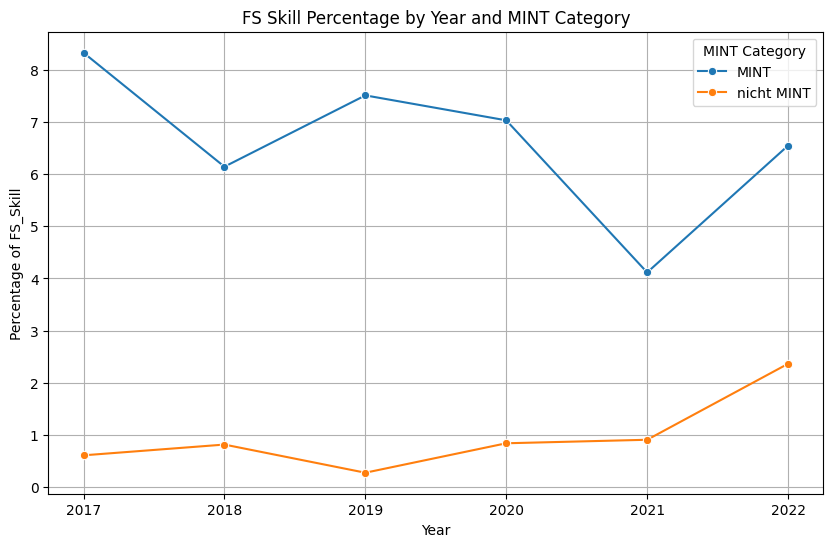

In [86]:
!pip install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fs_skill_percentage_by_year_mint = fs_skill_percentage_by_year_mint.reset_index()


# Beispiel: Daten in ein DataFrame umwandeln (ersetze dies durch dein echtes DataFrame)
# Hier gehe ich davon aus, dass 'fs_skill_percentage_by_year_mint' bereits als DataFrame vorliegt
# und die Spalten 'jahr', 'mint_faechergruppe', und 'FS_Skill' enthält.

# Plot erstellen
plt.figure(figsize=(10, 6))
sns.lineplot(data=fs_skill_percentage_by_year_mint, x='jahr', y='FS_Skill', hue='mint_faechergruppe', marker='o')

# Plot-Anpassungen
plt.xlabel('Year')
plt.ylabel('Percentage of FS_Skill')
plt.title('FS Skill Percentage by Year and MINT Category')
plt.legend(title='MINT Category')
plt.grid(True)

plt.show()


In [69]:
print(df_hex_sample.columns)


Index(['hochschulname_kurz', 'hochschule', 'fakultaet', 'fachbereich',
       'MINT_MN', 'MINT_T', 'institut', 'organisation', 'pfad',
       'studiengaenge', 'titel', 'nummer', 'url', 'dozierende',
       'veranstaltungsart', 'kursformat', 'lehrtyp', 'sprache',
       'primaersprache', 'sws', 'ects', 'kursbeschreibung', 'lernziele',
       'lernmethode', 'literatur', 'voraussetzungen', 'zusatzinformationen',
       'anmerkungen', 'teilnehmerzahl', 'pruefung', 'scrape_datum', 'semester',
       'jahr', 'studienbereich', 'faechergruppe', 'lufcode', 'sentence',
       'Pred_Tensor', 'FS_Skill'],
      dtype='object')
